# Answering Business Questions using SQL

In [1]:
# Import SQLite, Pandas and Matplotlib modules
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
%matplotlib inline

In [2]:
# Function to conect to database
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

In [3]:
# Function to run command
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

In [4]:
# Function to show tables that calls run query
def show_tables():
    with sqlite3.connect('chinook.db') as conn:
        q = '''SELECT name, type
               FROM sqlite_master
               WHERE type IN ("table","view");'''
        output = run_query(q)
        print(output)
        

In [5]:
# Run show_tables function
show_tables()

              name   type
0            album  table
1           artist  table
2         customer  table
3         employee  table
4            genre  table
5          invoice  table
6     invoice_line  table
7       media_type  table
8         playlist  table
9   playlist_track  table
10           track  table


In [6]:
# Genre Query
# Return each genre with number of tracks sold in USA in absolute numbers and in percentages
genre_USA_query = '''WITH usa_tracks_sold AS
   (SELECT il.* FROM invoice_line il
    INNER JOIN invoice i on il.invoice_id = i.invoice_id
    INNER JOIN customer c on i.customer_id = c.customer_id
    WHERE c.country = "USA")
    SELECT g.name genre, count(uts.invoice_line_id) tracks_sold,
    cast(count(uts.invoice_line_id) AS FLOAT) * 100 / 
    (SELECT COUNT(*) from usa_tracks_sold) percentage_sold
FROM usa_tracks_sold uts
INNER JOIN track t on t.track_id = uts.track_id
INNER JOIN genre g on g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10
'''
genre_USA_query_df = run_query(genre_USA_query)
print(genre_USA_query_df)

                genre  tracks_sold  percentage_sold
0                Rock          561        53.377735
1  Alternative & Punk          130        12.369172
2               Metal          124        11.798287
3            R&B/Soul           53         5.042816
4               Blues           36         3.425309
5         Alternative           35         3.330162
6               Latin           22         2.093245
7                 Pop           22         2.093245
8         Hip Hop/Rap           20         1.902950
9                Jazz           14         1.332065


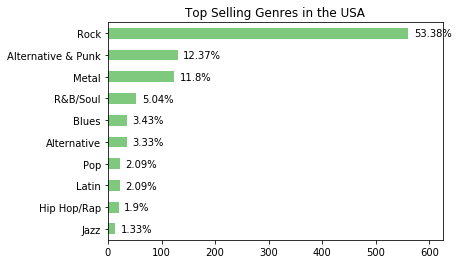

In [7]:
# Plot the genre query for USA
genre_sales_usa = run_query(genre_USA_query)
# Sorting by ascending, and then the bar chart sorts by descending
genre_sales_usa.sort_values('tracks_sold', ascending = True, inplace = True)
genre_sales_usa.set_index("genre", inplace=True, drop=True)

genre_sales_usa["tracks_sold"].plot.barh(
    title="Top Selling Genres in the USA",
    xlim=(0, 625),
    colormap=plt.cm.Accent
)

plt.ylabel('')

for i, label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label, "tracks_sold"]
    label = (genre_sales_usa.loc[label, "percentage_sold"] 
            ).astype(float).round(2).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))

plt.show()

# Summary of Genre sales

As seen from above plot, Rock is top selling genre and sells more than 50% of all sales.
Alternative & Punk and Metal are 2nd and 3rd.

Based on the sales of tracks across different genres in the USA, we should purchase the new albums by the following artists:

- Red Tone (Punk)
- Slim Jim Bites (Blues)
- Meteor and the Girls (Pop)

In [8]:
# Support Agent Sales Query
# Return agent name, title, hire_date and total dollar amount of sales assigned to each agent
agent_sales_query = '''SELECT e.first_name || " " || e.last_name employee, 
   e.title, substr(e.hire_date,1,10) hire_date, sum(i.total) total_sales
   FROM employee e
   INNER JOIN customer c on e.employee_id = c.support_rep_id
   INNER JOIN invoice i on c.customer_id = i.customer_id 
   GROUP BY e.employee_id
   ORDER BY total_sales desc
LIMIT 10
'''
agent_sales_query_df = run_query(agent_sales_query)
print(agent_sales_query_df)

        employee                title   hire_date  total_sales
0   Jane Peacock  Sales Support Agent  2017-04-01      1731.51
1  Margaret Park  Sales Support Agent  2017-05-03      1584.00
2  Steve Johnson  Sales Support Agent  2017-10-17      1393.92


                             title   hire_date  total_sales
employee                                                   
Steve Johnson  Sales Support Agent  2017-10-17      1393.92
Margaret Park  Sales Support Agent  2017-05-03      1584.00
Jane Peacock   Sales Support Agent  2017-04-01      1731.51


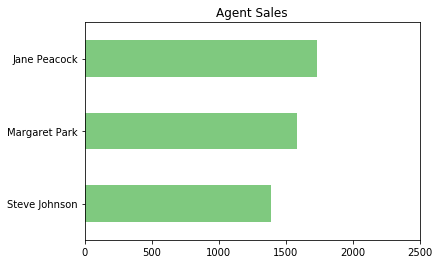

In [9]:
# Plot agent sales query from above
# Plot the genre query for USA
agent_sales = run_query(agent_sales_query)
# Sorting by ascending, and then the bar chart sorts by descending
agent_sales.sort_values('total_sales', ascending = True, inplace = True)
agent_sales.set_index('employee', inplace=True, drop=True)
emp_sales_bar = agent_sales["total_sales"].plot.barh(
    title="Agent Sales",
    xlim=(0, 2500),
    colormap=plt.cm.Accent
)

plt.ylabel('')
print(agent_sales)
plt.show()

# Results of Employee sales analysis
While there is a 20% difference in sales between Jane (the top employee) and Steve (the bottom employee), the difference roughly corresponds with the differences in their hiring dates.

In [10]:
# Analyze sales by country
# Country Sales Query
# Return country name, total customers, total sales value, avg sales per customer, avg order value
country_sales_query = '''
   WITH country_or_other AS
    (SELECT CASE
           WHEN (SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )
    SELECT country, customers, total_sales,
    average_sales_value, average_order_value
    FROM
    (SELECT country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct customer_id) average_sales_value,
        SUM(unit_price) / count(distinct invoice_id) average_order_value,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
'''
country_sales_query_df = run_query(country_sales_query)
country_sales_query_df

,country,customers,total_sales,average_sales_value,average_order_value
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,Other,15,1094.94,72.996000,7.448571


# Visualizing Sales by country

C:\Users\kruiz\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


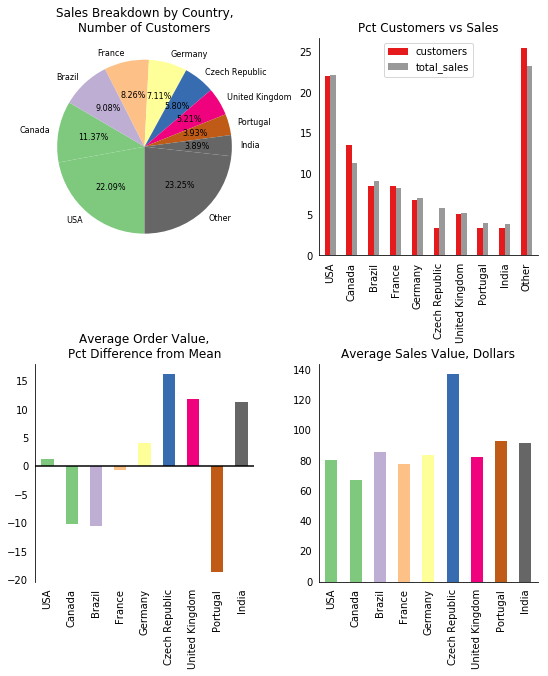

In [11]:
# For each dimension a visualization

country_metrics = run_query(country_sales_query)
country_metrics.set_index("country", drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)


# top left
sales_breakdown = country_metrics["total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    autopct='%1.2f%%',
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}    
)

# top right
cvd_cols = ["customers","total_sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

# bottom left
avg_order = country_metrics["average_order_value"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order Value,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
ltv = country_metrics["average_sales_value"].copy()
ltv.index.name = ''
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Average Sales Value, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()


Based on the data, there may be opportunity in the following countries:

- Czech Republic
- United Kingdom
- India

It's worth keeping in mind that because the amount of data from each of these countries is relatively low. Because of this, we should be cautious spending too much money on new marketing campaigns, as the sample size is not large enough to give us high confidence. A better approach would be to run small campaigns in these countries, collecting and analyzing the new customers to make sure that these trends hold with new customers.

# Albums vs Individual Tracks

In [12]:

albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    Round(CAST(count(invoice_id) AS FLOAT) * 100 / (SELECT COUNT(*) FROM invoice),2) percent
FROM
    (
    SELECT
        ifs.*,
        CASE WHEN
                 (SELECT t.track_id FROM track t
                  WHERE t.album_id = (SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,81.43
1,yes,114,18.57


Album purchases account for 18.57% of purchases. Based on this data, I would recommend against purchasing only select tracks from albums from record companies, since there is potential to lose one fifth of revenue.